In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from node2vec import Node2Vec
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import tarfile
from networkx.algorithms import community, centrality, assortativity
from collections import defaultdict
# For reproducibility
np.random.seed(42)



def load_graph(file_path="facebook.tar.gz"):
    G = nx.Graph()
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".edges"):
                f = tar.extractfile(member)
                for line in f:
                    node1, node2 = map(int, line.decode().strip().split())
                    G.add_edge(node1, node2)
    return G
G = load_graph()
print(G)

Graph with 3959 nodes and 84243 edges


In [26]:
def basic_visualization(G, title="Graph Visualization", seed=42):
    """
    Plots a basic spring-layout visualization of the given (small) graph.
    """
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx(G, pos=pos, node_size=500, font_size=8)
    plt.title(title)
    plt.show()

In [27]:
def compute_and_show_centralities(G):
    """
    Computes and prints top 5 Degree Centrality and Betweenness Centrality.
    Also plots the histogram of degree centrality distribution.
    """
    print("--- Centrality Measures ---")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    deg_sorted = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 nodes by Degree Centrality:")
    for node, val in deg_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")

    # Betweenness Centrality
    bet_centrality = nx.betweenness_centrality(G)
    bet_sorted = sorted(bet_centrality.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 nodes by Betweenness Centrality:")
    for node, val in bet_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")

    # Plot distribution of degree centralities
    plt.figure(figsize=(6,4))
    plt.hist(list(deg_centrality.values()), bins=10, edgecolor='black')
    plt.title("Distribution of Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.show()


In [28]:

def detect_communities_louvain(G):
    """
    Runs Louvain community detection and returns:
      - partition (dict of node->community_id)
      - modularity
      - groups (community_id -> list of nodes)
    """
    partition = community_louvain.best_partition(G)
    mod_val = community_louvain.modularity(partition, G)
    
    groups = defaultdict(list)
    for node, comm_id in partition.items():
        groups[comm_id].append(node)
    
    return partition, mod_val, groups


def detect_communities_girvan_newman(G):
    """
    Runs Girvan-Newman and returns:
      - The *first* split (2 communities)
      - A dictionary for node->community_id
      - Modularity of that 2-community split
    """
    gn_iter = nx.algorithms.community.girvan_newman(G)
    first_partition = next(gn_iter)
    communities = list(sorted(map(sorted, first_partition)))

    # Convert partition to dict for modularity
    partition_dict = {}
    for i, comm_nodes in enumerate(communities):
        for n in comm_nodes:
            partition_dict[n] = i

    # Reuse Louvain's modularity function for convenience
    mod_gn = community_louvain.modularity(partition_dict, G)

    return communities, partition_dict, mod_gn


In [29]:
def spectral_clustering(G, k=3):
    """
    Performs a spectral embedding (normalized Laplacian),
    then runs KMeans (k clusters), and returns:
      - cluster labels
      - silhouette score
      - a DataFrame of (Node, Cluster)
    """
    L = nx.normalized_laplacian_matrix(G)
    L_dense = L.toarray()
    vals, vecs = np.linalg.eig(L_dense)

    # Sort eigenvalues & eigenvectors
    idx_sorted = np.argsort(vals)
    vecs_sorted = vecs[:, idx_sorted]

    # Take first k eigenvectors
    X_spectral = vecs_sorted[:, :k]

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_spectral)

    sil_score = silhouette_score(X_spectral, labels)
    df_spectral = pd.DataFrame({'Node': list(G.nodes()), 'Cluster': labels})

    return labels, sil_score, df_spectral


In [30]:
def node2vec_clustering(G, dimensions=8, walk_length=10, num_walks=20, k=3):
    """
    Runs Node2Vec to generate embeddings,
    then KMeans (k clusters),
    and returns cluster labels, silhouette, and a DataFrame of (Node, Cluster).
    """
    node2vec = Node2Vec(
        G,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=1
    )
    model_n2v = node2vec.fit(window=5, min_count=1, batch_words=4)

    # Build embedding matrix
    nodes_list = sorted(G.nodes())
    embeddings_n2v = []
    for n in nodes_list:
        vec = model_n2v.wv[str(n)]  # keys are strings in node2vec
        embeddings_n2v.append(vec)

    embeddings_n2v = np.array(embeddings_n2v)

    kmeans_n2v = KMeans(n_clusters=k, random_state=42)
    labels_n2v = kmeans_n2v.fit_predict(embeddings_n2v)

    sil_n2v = silhouette_score(embeddings_n2v, labels_n2v)
    df_n2v = pd.DataFrame({'Node': nodes_list, 'Cluster': labels_n2v})

    return labels_n2v, sil_n2v, df_n2v

In [31]:
def analyze_graph(G, graph_name="Graph", do_plot=True):
    """
    Runs the entire pipeline on a given graph:
      1. Basic Info & Visualization (if do_plot=True)
      2. Centralities
      3. Louvain & Girvan-Newman
      4. Spectral Clustering
      5. Node2Vec
      6. Prints out comparisons

    :param G: NetworkX graph
    :param graph_name: Name/label for printing/plots
    :param do_plot: If True, draws a quick layout of the graph (suitable for small graphs)
    """
    print(f"\n==== Analyzing {graph_name} ====")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # 1) Visualization
    if do_plot and G.number_of_nodes() <= 200:
        # For large graphs, a spring layout might be slow or cluttered
        basic_visualization(G, title=f"{graph_name} Visualization")

    # 2) Centralities
    compute_and_show_centralities(G)

    # 3) Community Detection
    print("\n--- Louvain Community Detection ---")
    louvain_partition, mod_louvain, louvain_groups = detect_communities_louvain(G)
    print(f"Louvain found {len(louvain_groups)} communities; Modularity = {mod_louvain:.4f}")
    # Show the communities if not too big
    if len(G) < 50:
        for cid, members in louvain_groups.items():
            print(f"  Community {cid}: {members}")

    print("\n--- Girvan-Newman (First Split => 2 communities) ---")
    gn_communities, gn_partition_dict, mod_gn = detect_communities_girvan_newman(G)
    print(f"Girvan-Newman first split => 2 communities; Modularity = {mod_gn:.4f}")
    if len(G) < 50:
        print(f"  GN Community 1: {gn_communities[0]}")
        print(f"  GN Community 2: {gn_communities[1]}")

    # 4) Spectral Clustering
    print("\n--- Spectral Clustering (k=3) ---")
    labels_spectral, sil_spectral, df_spectral = spectral_clustering(G, k=3)
    print(f"Spectral silhouette (k=3) = {sil_spectral:.4f}")
    # Optionally show the partition
    if len(G) < 50:
        print(df_spectral.groupby('Cluster')['Node'].apply(list))

    # 5) Node2Vec
    print("\n--- Node2Vec + KMeans (k=3) ---")
    labels_n2v, sil_n2v, df_n2v = node2vec_clustering(G, k=3)
    print(f"Node2Vec silhouette (k=3) = {sil_n2v:.4f}")
    if len(G) < 50:
        print(df_n2v.groupby('Cluster')['Node'].apply(list))

    # 6) Compare & Observations
    print("\n--- Comparison & Observations ---")
    print(f" > Louvain Modularity:       {mod_louvain:.4f}")
    print(f" > Girvan-Newman Modularity: {mod_gn:.4f} (2 communities)")
    print(f" > Spectral Silhouette:      {sil_spectral:.4f} (k=3)")
    print(f" > Node2Vec Silhouette:      {sil_n2v:.4f}  (k=3)")

    print(f"\nDone analyzing {graph_name}.\n")


==== Analyzing Zachary's Karate Club ====
Nodes: 34, Edges: 78


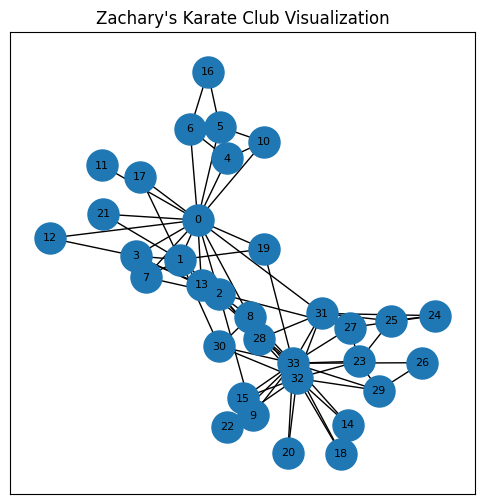

--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 33 => 0.515
  Node 0 => 0.485
  Node 32 => 0.364
  Node 2 => 0.303
  Node 1 => 0.273

Top 5 nodes by Betweenness Centrality:
  Node 0 => 0.438
  Node 33 => 0.304
  Node 32 => 0.145
  Node 2 => 0.144
  Node 31 => 0.138


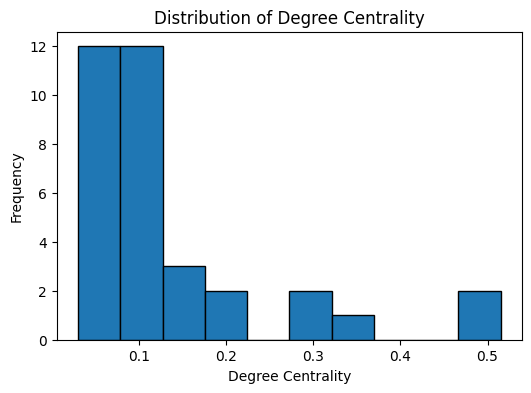


--- Louvain Community Detection ---
Louvain found 4 communities; Modularity = 0.4439
  Community 0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 1: [4, 5, 6, 10, 16]
  Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]
  Community 2: [24, 25, 28, 31]

--- Girvan-Newman (First Split => 2 communities) ---
Girvan-Newman first split => 2 communities; Modularity = 0.3477
  GN Community 1: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
  GN Community 2: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

--- Spectral Clustering (k=3) ---
Spectral silhouette (k=3) = 0.5682
Cluster
0              [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
1    [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27,...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Node2Vec + KMeans (k=3) ---


Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 624.91it/s]


Node2Vec silhouette (k=3) = 0.1834
Cluster
0    [9, 11, 12, 15, 17, 18, 22, 24, 25, 26, 29, 31...
1    [0, 1, 2, 3, 7, 8, 13, 14, 19, 20, 21, 23, 27,...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Comparison & Observations ---
 > Louvain Modularity:       0.4439
 > Girvan-Newman Modularity: 0.3477 (2 communities)
 > Spectral Silhouette:      0.5682 (k=3)
 > Node2Vec Silhouette:      0.1834  (k=3)

Done analyzing Zachary's Karate Club.



In [32]:
G_karate = nx.karate_club_graph()
analyze_graph(G_karate, graph_name="Zachary's Karate Club", do_plot=True)